In [2]:
from sklearn import datasets
import numpy as np

In [3]:
iris = datasets.load_iris()
#X = iris["data"][:,3:]  # petal width
X = iris["data"][:,:]
y = (iris["target"]==2).astype(np.int)
X.shape, y.shape

((150, 4), (150,))

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((108, 4), (27, 4), (15, 4))

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [6]:
def binary_loss(X, Y, weights, alpha=0.00001):
    """
    X.shape = (num_instances, num_features)
    Y.shape = (num_instances,)
    weights.shape = (num_features,)
    """
    z = np.dot(X, weights)
    h = sigmoid(z)
    total_cost = (-Y*np.log(h) - (1-Y)*np.log(1-h)).mean() + alpha * np.sum(np.dot(weights, weights.T))
    return total_cost

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    train_loss_history, val_loss_history = [], []
    num_features = X_tr.shape[1]
    weights = np.zeros(shape=(num_features,), dtype=np.float64)
    clip_value = 1e-9
    X_tr = np.clip(X_tr, clip_value, 1-clip_value)
    mms = MinMaxScaler()
    #mms = StandardScaler()
    X_tr = mms.fit_transform(X_tr)
    for epoch in range(epochs):
        indices = np.arange(X_tr.shape[0])
        np.random.shuffle(indices)
        X_tr = X_tr[indices]
        Y_tr = Y_tr[indices]

        # training loop
        train_loss = 0
        for idx, row in enumerate(X_tr):
            row = np.reshape(row, (1, num_features))
            train_loss = binary_loss(row, Y_tr[idx], weights, alpha)
            for i in range(len(row)):
                gradient = (sigmoid(row @ weights) - float(Y_tr[idx])) * row[0, i] + alpha*weights[i]
                weights[i] = weights[i] - lr*gradient
        train_loss /= X_tr.shape[0]
        train_loss_history.append(train_loss)

        if len(X_dev) != 0 and len(Y_dev) != 0:
            X_dev = mms.transform(X_dev)
            val_loss = binary_loss(X_dev, Y_dev, weights, alpha)
            val_loss_history.append(val_loss)

            if print_progress:
                print(f"Epoch: {epoch+1}")
                print(f"Training loss:   {train_loss:.4f}")
                print(f"Validation loss: {val_loss:.4f}")

            # Stopper training des que val_loss ne decroit plus.
            if epoch >=1:
                if np.abs(val_loss_history[epoch]-val_loss_history[epoch-1]) < tolerance:
                    break

    return weights, train_loss_history, val_loss_history

In [17]:
n_epochs = 100
w, train_hist, val_hist = SGD(X_train, y_train, X_dev=X_val, Y_dev=y_val, epochs=n_epochs, print_progress=True)

Epoch: 1
Training loss:   0.0064
Validation loss: 0.6931
Epoch: 2
Training loss:   0.0064
Validation loss: 0.6931


In [15]:
train_hist

[0.0064180294496291234, 0.0064180294496291234]

In [16]:
val_hist

[0.6931471805599451, 0.6931471805599451]

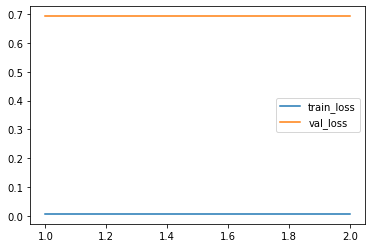

In [18]:
import matplotlib.pyplot as plt
x = range(1, len(train_hist)+1)
plt.plot(x, train_hist, label="train_loss")
plt.plot(x, val_hist, label="val_loss")
plt.legend();

In [ ]:
#prediction = 

### Let's try to train with `LogisticRegression`

In [20]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
y_val_pred = log_reg.predict(X_val)
confusion_matrix(y_val, y_val_pred)

array([[17,  0],
       [ 0, 10]])

In [27]:
y_test_pred = log_reg.predict(X_test)
confusion_matrix(y_test, y_test_pred)

array([[12,  0],
       [ 0,  3]])

### Bias term
Maybe the problem was that we do not manually add a bias term?

In [28]:
X_train.shape

(108, 4)

In [31]:
X_t = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_t.shape

(108, 5)

In [32]:
X_v = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_v.shape

(27, 5)

In [35]:
n_epochs = 100
w, train_hist, val_hist = SGD(X_t, y_train, X_dev=X_v, Y_dev=y_val, epochs=n_epochs, print_progress=False)

In [36]:
train_hist

[0.0064180294496291234, 0.0064180294496291234]

In [37]:
val_hist

[0.6931471805599451, 0.6931471805599451]

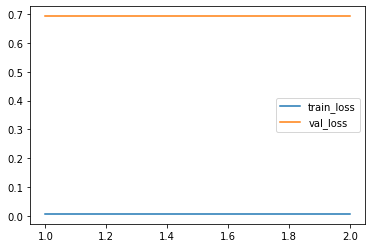

In [38]:
import matplotlib.pyplot as plt
x = range(1, len(train_hist)+1)
plt.plot(x, train_hist, label="train_loss")
plt.plot(x, val_hist, label="val_loss")
plt.legend();

No, this is not where the problem lies.